In [1]:
from ftfy import fix_encoding

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import nltk as nlp
import re
import csv

nlp.download("stopwords")

import matplotlib.pyplot as plt

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

def fix_encode(x):
    return fix_encoding(x)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

data = pd.read_csv(
    "datasets/mc-dataset-1.csv",
    encoding="utf-8",
    header=0,
    delimiter=";",
    quoting=csv.QUOTE_ALL
)

CONVERT_DICT={
    'text': str,
    'env_problems': int,
    'pollution': int,
    'treatment': int,
    'climate': int, 
    'biomonitoring': int
}


data = data.fillna(0)

data=data.astype(CONVERT_DICT)

# data.head()

In [3]:
data.shape
data.columns
data.head()

,text,env_problems,pollution,treatment,climate,biomonitoring
0,In the Southern Bug basin wastewater is discharged from 341 organized sources (Map 5). In 2011 (reference year) 211 mln. m3 was discharged in total.,1,1,0,0,0
1,This amount is distributed as follows: urban and rural housing wastewater treatment facilities (WWTPs - vodocanals) – 70 mln. m3 (57 users) industry – 50 mln. m3 (79 users) agriculture – 90 mln. m3 (193 users) other users – 1 mln. m3 (12 users) (Picture. 2.1).,1,1,0,0,0
2,Despite the similar volumes of discharged wastewater major part of pollutants comes with communal WWTPs.,1,1,0,0,0
3,They bring 84% of organic pollution 86% of phosphate ions and 84% of mineral nitrogen 91% of ammonia nitrogen 87% nitrate nitrogen and 79% nitrite nitrogen.,1,1,0,0,0
4,The input of the industry is between 7–21% and agriculture has the lowest impact on water bodies - 0–6%. Of the 92 urban areas only 51 localities (55%) have centralized collection of communal waste waters and their monitoring. Among the 2878 villages 6 of them (0.2%) have such a monitoring.,1,1,0,0,0


In [4]:
data.text = data.text.apply(lambda x: fix_encode(x))
data['text']=data['text'].apply(lambda x : remove_URL(x))
data['text']=data['text'].apply(lambda x : remove_html(x))
data['text']=data['text'].apply(lambda x : remove_emoji(x))

In [5]:
target = data[['env_problems', 'pollution', 'treatment', 'climate', 'biomonitoring']]
target.head()

,env_problems,pollution,treatment,climate,biomonitoring
0,1,1,0,0,0
1,1,1,0,0,0
2,1,1,0,0,0
3,1,1,0,0,0
4,1,1,0,0,0


<AxesSubplot:>

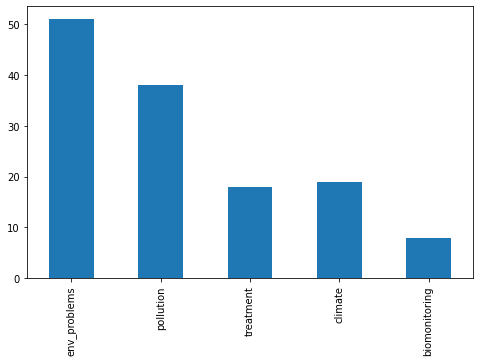

In [6]:
fig_size = plt.rcParams['figure.figsize']
fig_size[0]=8
fig_size[1]=5
plt.rcParams['figure.figsize'] = fig_size

target.sum(axis=0).plot.bar()

In [7]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [8]:
from nltk.corpus import stopwords

lemma = nlp.WordNetLemmatizer()

X = []
# sentences = list(data['text'])

for each in data.text:
    each = re.sub("[^a-zA-Z]"," ", str(each))                                        # regex to clean unnecesarry chars
    each = each.lower()                                                              # lowercase all
    each = nlp.word_tokenize(each)                                                   # split all by tokenizing
    each = [word for word in each if not word in set(stopwords.words("english"))]    # delete stop words from your array
    each = [lemma.lemmatize(word) for word in each]                                  # lemmatize "memories" -> "memory"
    each = " ".join(each)                                                            # make them one string again
    each = preprocess_text(each)
    # each = correct_spellings(each)                                                   # correct the spelling (?)
    X.append(each)                                                         # put them into big array

y = target.values

In [9]:
print(X[15:25])

['method allows extracting part pollutant containing nitrogen phosphorus', 'technology deep extraction compound used ukraine due high cost', 'existing wastewater treatment facility constructed soviet time physically technologically outdated work inefficiently', 'often volume wastewater exceed designed value lead additional pollution', 'wastewater treatment facility require urgent modernization reconstruction', 'according obtained data wastewater facility lowest efficiency regarding ninorg treatment vatutino tulchin bashtanka smoline settlement', 'wastewater facility large city namely kirovograd vinnistya khmelnitsky also work ineffectively lead increased contains nitrogen surface water', 'tendency compound nh inorganic nitrogen total', 'major discharge done three main city vinnitsa khmelnitsky kirovograd observe direct dependency discharge number population', 'time significant discharge ammonia nitrogen done wwtps vatutino bashtanka tulchin khrystynivka also related improper functionin

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [11]:
maxlen = 200

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [12]:
from numpy import asarray

embeddings_dictionary = dict()
GLOVE_FILENAME = 'glove.42B.300d.txt'
EMBEDDING_VECTOR_LENGTH = 300 #<=200

with open(GLOVE_FILENAME, 'r', encoding='utf-8') as f:
    for line in f:
        records = line.split()
        word = records[0]
        vector_dimensions = asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions

f.close()


embedding_matrix = np.zeros((vocab_size, EMBEDDING_VECTOR_LENGTH))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector 

In [13]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [14]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, EMBEDDING_VECTOR_LENGTH, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(5, activation='sigmoid')(LSTM_layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', f1_m, precision_m, recall_m])

In [53]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 300)          132300    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 352,593
Trainable params: 220,293
Non-trainable params: 132,300
_________________________________________________________________
None


In [64]:
history = model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=2, validation_split=0.4)

Epoch 1/10
2/2 - 1s - loss: 0.5570 - acc: 0.7778 - f1_m: 0.3718 - precision_m: 0.4219 - recall_m: 0.3529 - val_loss: 0.5498 - val_acc: 0.7917 - val_f1_m: 0.4211 - val_precision_m: 0.5000 - val_recall_m: 0.3636
Epoch 2/10
2/2 - 0s - loss: 0.5574 - acc: 0.7778 - f1_m: 0.4250 - precision_m: 0.5312 - recall_m: 0.3542 - val_loss: 0.5490 - val_acc: 0.7917 - val_f1_m: 0.4211 - val_precision_m: 0.5000 - val_recall_m: 0.3636
Epoch 3/10
2/2 - 0s - loss: 0.5572 - acc: 0.7778 - f1_m: 0.4444 - precision_m: 0.5312 - recall_m: 0.3837 - val_loss: 0.5478 - val_acc: 0.7917 - val_f1_m: 0.4211 - val_precision_m: 0.5000 - val_recall_m: 0.3636
Epoch 4/10
2/2 - 0s - loss: 0.5567 - acc: 0.7778 - f1_m: 0.4695 - precision_m: 0.5312 - recall_m: 0.4300 - val_loss: 0.5467 - val_acc: 0.7917 - val_f1_m: 0.4211 - val_precision_m: 0.5000 - val_recall_m: 0.3636
Epoch 5/10
2/2 - 0s - loss: 0.5565 - acc: 0.7778 - f1_m: 0.3457 - precision_m: 0.4219 - recall_m: 0.2939 - val_loss: 0.5460 - val_acc: 0.7917 - val_f1_m: 0.4211

In [65]:
scores = model.evaluate(X_test, y_test, verbose=2, batch_size=32)

2/2 - 0s - loss: 0.5145 - acc: 0.8000 - f1_m: 0.4496 - precision_m: 0.4844 - recall_m: 0.4196


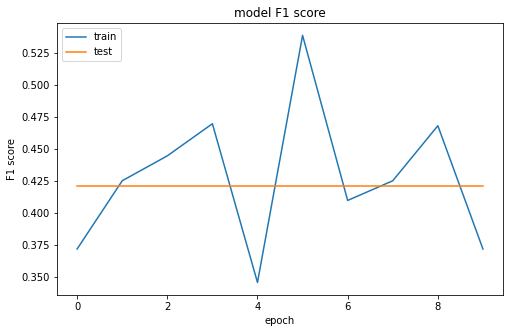

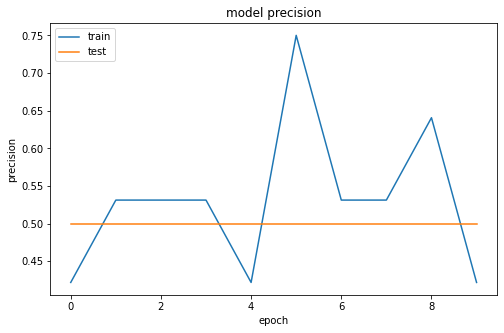

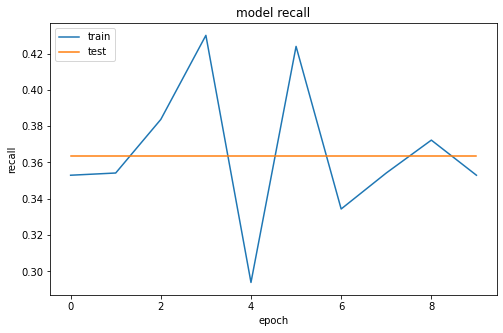

In [69]:
import matplotlib.pyplot as plt

plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
    
plt.title('model F1 score')
plt.ylabel('F1 score')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])

plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])

plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()